W207 final project, Spring 2015

Kevin Allen, Doug Kelley, Rosalind Lee, Mandeepak Singh (in alphabetical order)

The general approach is based on http://nbviewer.ipython.org/github/aguschin/kaggle/blob/master/forestCoverType_featuresEngineering.ipynb

In [1]:
import pandas as pd
from sklearn import ensemble
%pylab inline
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
train=pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

The first 11 columns have readable values; the next 4 code for wilderness; and the final 40 code for soil type

Look at the first 11 columns for a couple of instances 

In [3]:
train.ix[:3,:11]

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points
0,1,2596,51,3,258,0,510,221,232,148,6279
1,2,2590,56,2,212,-6,390,220,235,151,6225
2,3,2804,139,9,268,65,3180,234,238,135,6121
3,4,2785,155,18,242,118,3090,238,238,122,6211


Now plot out histograms of these first 10 variables (after id)

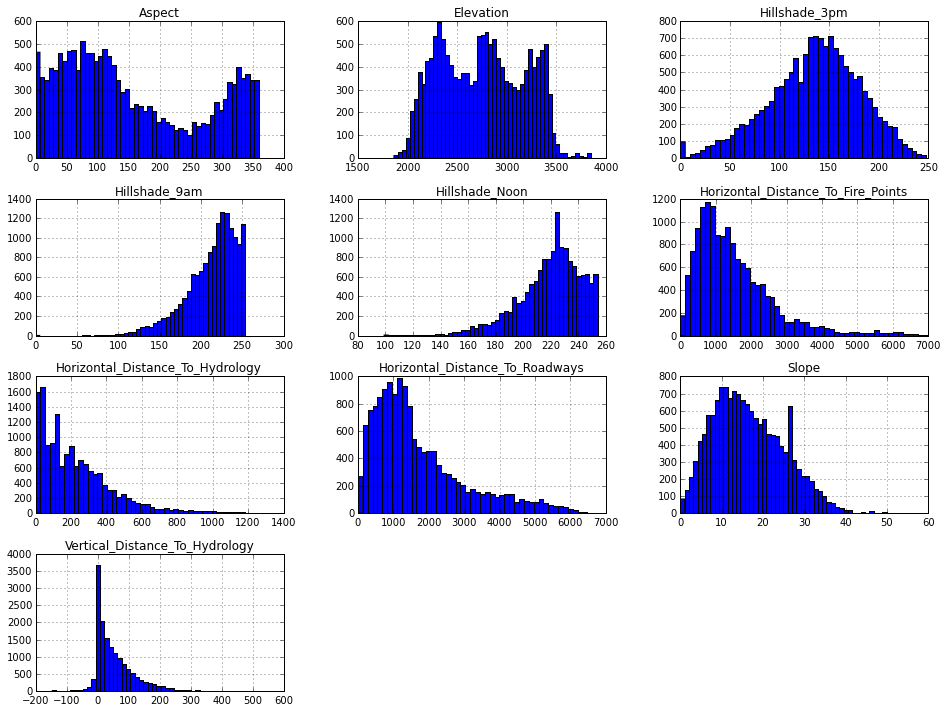

In [5]:
train.ix[:,1:11].hist(figsize=(16,12),bins=50)
plt.show()

Try to recenter the aspect variable

In [6]:
def r(x):
    if x+180>360:
        return x-180
    else:
        return x+180

train['Aspect2'] = train.Aspect.map(r)
test['Aspect2'] = test.Aspect.map(r)

Let's look at the correlation between Elevation and Vertical_Distance_to_Hydrology for different cover types

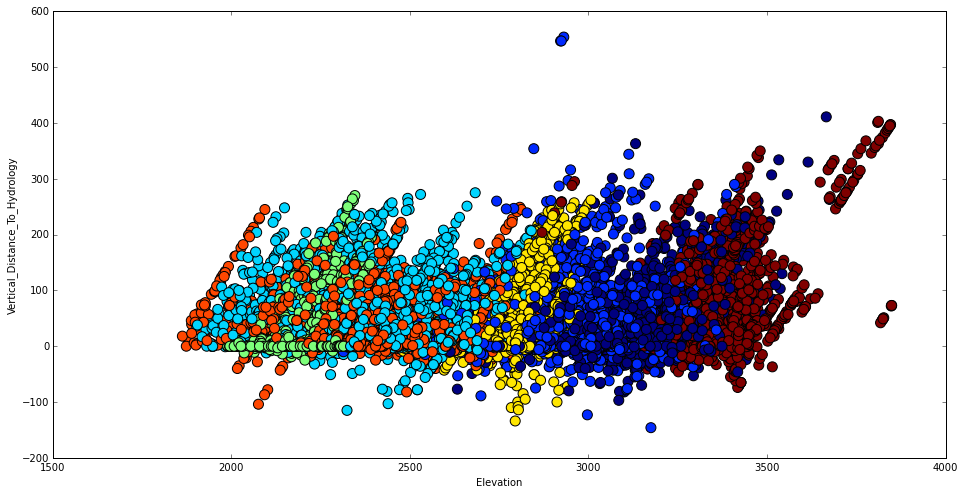

In [7]:
def plotc(c1,c2):

    fig = plt.figure(figsize=(16,8))
    sel = np.array(list(train.Cover_Type.values))

    plt.scatter(c1, c2, c=sel, s=100)
    plt.xlabel(c1.name)
    plt.ylabel(c2.name)
    
plotc(train.Elevation, train.Vertical_Distance_To_Hydrology)


Points are labelled by cover type; interesting that they seem to cluster somewhat.
Create a new variable to bin these a little bit better

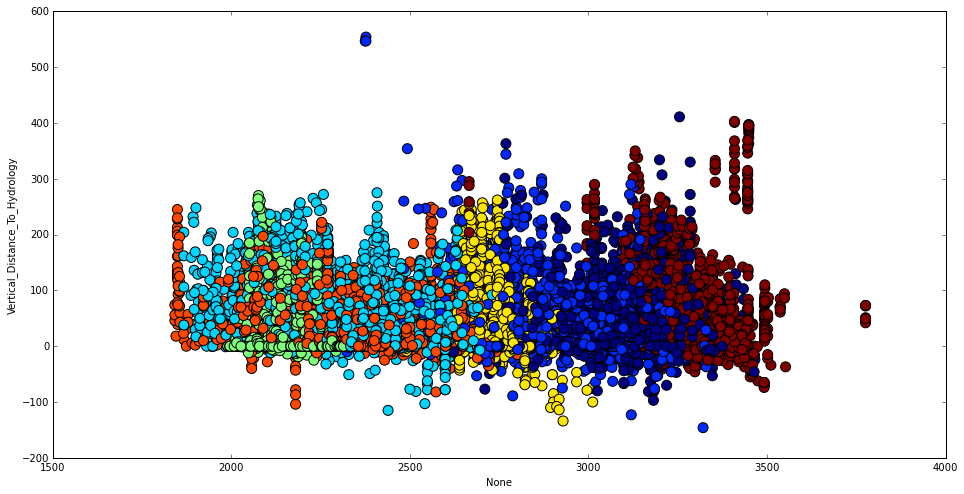

In [9]:
plotc(train.Elevation-train.Vertical_Distance_To_Hydrology, train.Vertical_Distance_To_Hydrology)
train['EVDtH'] = train.Elevation-train.Vertical_Distance_To_Hydrology
test['EVDtH'] = test.Elevation-test.Vertical_Distance_To_Hydrology

train['EHDtH'] = train.Elevation-train.Horizontal_Distance_To_Hydrology*0.2
test['EHDtH'] = test.Elevation-test.Horizontal_Distance_To_Hydrology*0.2


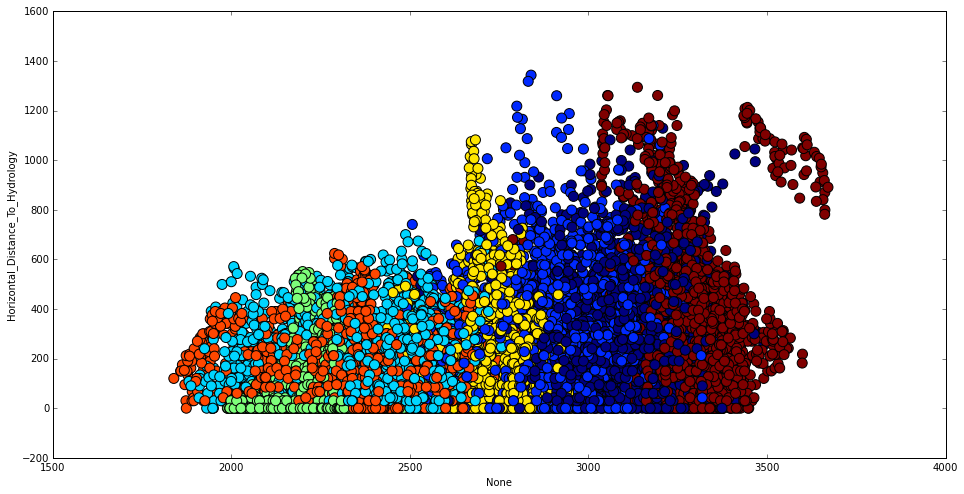

In [11]:
plotc(train.Elevation-train.Horizontal_Distance_To_Hydrology*0.2, train.Horizontal_Distance_To_Hydrology)

More spread than the previous variable, but still some segregation

Calculate some more distances

In [12]:
train['Distanse_to_Hydrolody'] = (train['Horizontal_Distance_To_Hydrology']**2+train['Vertical_Distance_To_Hydrology']**2)**0.5
test['Distanse_to_Hydrolody'] = (test['Horizontal_Distance_To_Hydrology']**2+test['Vertical_Distance_To_Hydrology']**2)**0.5

train['Hydro_Fire_1'] = train['Horizontal_Distance_To_Hydrology']+train['Horizontal_Distance_To_Fire_Points']
test['Hydro_Fire_1'] = test['Horizontal_Distance_To_Hydrology']+test['Horizontal_Distance_To_Fire_Points']

train['Hydro_Fire_2'] = abs(train['Horizontal_Distance_To_Hydrology']-train['Horizontal_Distance_To_Fire_Points'])
test['Hydro_Fire_2'] = abs(test['Horizontal_Distance_To_Hydrology']-test['Horizontal_Distance_To_Fire_Points'])

train['Hydro_Road_1'] = abs(train['Horizontal_Distance_To_Hydrology']+train['Horizontal_Distance_To_Roadways'])
test['Hydro_Road_1'] = abs(test['Horizontal_Distance_To_Hydrology']+test['Horizontal_Distance_To_Roadways'])

train['Hydro_Road_2'] = abs(train['Horizontal_Distance_To_Hydrology']-train['Horizontal_Distance_To_Roadways'])
test['Hydro_Road_2'] = abs(test['Horizontal_Distance_To_Hydrology']-test['Horizontal_Distance_To_Roadways'])

train['Fire_Road_1'] = abs(train['Horizontal_Distance_To_Fire_Points']+train['Horizontal_Distance_To_Roadways'])
test['Fire_Road_1'] = abs(test['Horizontal_Distance_To_Fire_Points']+test['Horizontal_Distance_To_Roadways'])

train['Fire_Road_2'] = abs(train['Horizontal_Distance_To_Fire_Points']-train['Horizontal_Distance_To_Roadways'])
test['Fire_Road_2'] = abs(test['Horizontal_Distance_To_Fire_Points']-test['Horizontal_Distance_To_Roadways'])

Look at hillshade some more

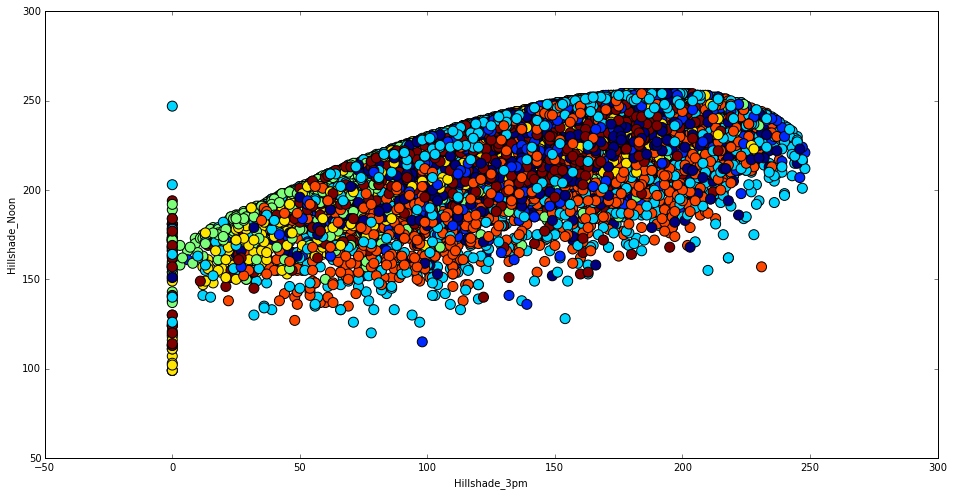

In [13]:
plotc(train.Hillshade_3pm, train.Hillshade_Noon)

Some missing data at 3pm but still an interesting pattern

Set up an Extra Trees Classifier on this data

In [16]:
feature_cols = [col for col in train.columns if col not in ['Cover_Type','Id']]

X_train = train[feature_cols]
X_test = test[feature_cols]
y = train['Cover_Type']
test_ids = test['Id']

forest = ensemble.ExtraTreesClassifier(n_estimators=400, criterion='gini', max_depth=None, 
    min_samples_split=2, min_samples_leaf=1, max_features='auto', 
    bootstrap=False, oob_score=False, n_jobs=-1, random_state=None, verbose=0)

In [17]:
forest.fit(X_train, y)

with open('FEbenchmark.csv', "wb") as outfile:
    outfile.write("Id,Cover_Type\n")
    for e, val in enumerate(list(forest.predict(X_test))):
        outfile.write("%s,%s\n"%(test_ids[e],val))

####This version scored an accuracy of 0.79301

Add a variable to explicitly consider how south facing the location is

In [19]:
X_train['south_face'] = [180 - a if a <=180 else a - 180  for a in X_train.Aspect]
X_train['south_x_slope'] = X_train.south_face * X_train.Slope
X_test['south_face']= [180 - a if a <=180 else a - 180  for a in X_test.Aspect]
X_test['south_x_slope'] = X_test.south_face * X_test.Slope

Fit a new classifier inlcuding these variables

In [21]:
forest2 = ensemble.ExtraTreesClassifier(n_estimators=400, criterion='gini', max_depth=None, 
    min_samples_split=2, min_samples_leaf=1, max_features='auto', 
    bootstrap=False, oob_score=False, n_jobs=-1, random_state=None, verbose=0)

forest2.fit(X_train, y)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [23]:
with open('fe_south.csv', "wb") as outfile:
    outfile.write("Id,Cover_Type\n")
    for e, val in enumerate(list(forest2.predict(X_test))):
        outfile.write("%s,%s\n"%(test_ids[e],val))

This version scored an accuracy of **0.80683**

How well should we be able to do?

This is a pretty aggressive train/test split, and it would be helpful to benchmark against the full dataset.

The dataset is available at https://archive.ics.uci.edu/ml/datasets/Covertype

There is also a spark/MLLib implementation and walkthrough at https://github.com/sryza/aas/blob/master/ch04-rdf/src/main/scala/com/cloudera/datascience/rdf/RunRDF.scala 

Let's pull out a subset of this and look at the accuracy of MLLib's RandomForest classifier for different splits

Here's some scala code adapted from the Advnaced Analytics in Spark github repo

    import org.apache.spark.mllib.evaluation.MulticlassMetrics
    import org.apache.spark.mllib.linalg.Vectors
    import org.apache.spark.mllib.regression.LabeledPoint
    import org.apache.spark.mllib.tree.{RandomForest, DecisionTree}
    import org.apache.spark.mllib.tree.model.DecisionTreeModel
    import org.apache.spark.rdd.RDD
    import org.apache.spark.{SparkConf, SparkContext}
    object RunRDF {

      def main(args: Array[String]): Unit = {
        val sc = new SparkContext(new SparkConf().setAppName("RDF"))
        val rawData = sc.textFile("covtype.data")

        val data = rawData.map { line =>
              val values = line.split(',').map(_.toDouble)
              val featureVector = Vectors.dense(values.init)
              val label = values.last - 1
              LabeledPoint(label, featureVector)
         }

        evaluateForest(rawData)
      }
  
      def unencodeOneHot(rawData: RDD[String]): RDD[LabeledPoint] = {
           rawData.map { line =>
               val values = line.split(',').map(_.toDouble)
                // Which of 4 "wilderness" features is 1
               val wilderness = values.slice(10, 14).indexOf(1.0).toDouble
               // Similarly for following 40 "soil" features
               val soil = values.slice(14, 54).indexOf(1.0).toDouble
               // Add derived features back to first 10
               val featureVector = Vectors.dense(values.slice(0, 10) :+ wilderness :+ soil)
               val label = values.last - 1
               LabeledPoint(label, featureVector)
            }
       }
  
      def evaluateForest(rawData: RDD[String]): Unit = {

          val data = unencodeOneHot(rawData)
          // Vary the train/test split here to look at accuracy entitlement
          val Array(trainData, cvData) = data.randomSplit(Array(0.9, 0.1))
          trainData.cache()
          cvData.cache()

          val forest = RandomForest.trainClassifier(
                 trainData, 7, Map(10 -> 4, 11 -> 40), 20, "auto", "entropy", 30, 300)

          val predictionsAndLabels = cvData.map(example =>
                      (forest.predict(example.features), example.label))
          println(new MulticlassMetrics(predictionsAndLabels).precision)

        }
    }

With a 90/10 split, we get 96.5% accuracy

70/30: 96.0%

50/50: 95.2%

30/70: 94.0%

10/90: 89.5%

5/95: 86.3%

2/98: 81.1%

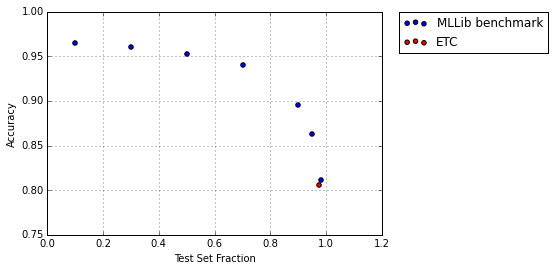

In [31]:
testsplit=[0.1,0.3,0.5,0.7,0.9,0.95,0.98]
rfacc=[0.965,0.960,0.952,0.940,0.895,0.863,0.811]
plt.scatter(testsplit,rfacc, label='MLLib benchmark')
plt.scatter(float(test.shape[0])/float(train.shape[0]+test.shape[0]),0.806, c='red',label='ETC')
plt.grid()
plt.xlabel('Test Set Fraction')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [33]:
print 'Our split is %0.6g'%(float(test.shape[0])/float(train.shape[0]+test.shape[0]))

Our split is 0.973976


We should probably be able to do a bit better than this